Loading relevant tools libraires

In [ ]:
from keras.datasets import cifar10
import keras.utils as utils
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Flatten,Dense,Dropout
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

Preprocessing data

In [ ]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#normalise label data by finding binary representation
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#normalise image data by finding binary representation
x_train = x_train.astype("float32")
x_train = x_train / 255.0
x_test = x_test.astype("float32")
x_test = x_test / 255.0

Function to define my model

In [ ]:
def define_model(lr):
  # model architecure
  # Sequential allows for adding layers in order
  model = Sequential()
  # Conv2D get the feautre map output
  model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 input_shape=(32, 32, 3), activation="relu", padding ="same",
                 kernel_constraint=maxnorm(3)))
  # Maxpool layers set to 32x32 16x16 reduce training time and expense
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=32, kernel_size=(5, 5),
                 input_shape=(32, 32, 3), activation="relu", padding ="same",
                 kernel_constraint=maxnorm(3)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Flatten matrix to 1D array
  model.add(Flatten())
  #Generates the prediction network 600 units as it provides reasonably good
  # results without high expense
  model.add(Dense(units=600, activation="relu", kernel_constraint=maxnorm(3)))
  # dropout helps prevent overfitting
  model.add(Dropout(rate=0.5))
  # last dense layer to generate output for 10 classes
  model.add(Dense(units=10, activation="softmax"))
  # model compilation
  # sgd optimiser to reduce generalisation error
  # categorical cross entrophy as images can only belong to one label
  model.compile(optimizer=SGD(learning_rate=lr),
              loss="categorical_crossentropy", metrics=["accuracy"])
  
  return model

Functions used to define resnet model

In [ ]:
# the input image sizes are 32 x 32, upsampling by 7x7 transforms them to 224 x 224
def resize_images1(X):
    return tf.keras.backend.resize_images(X, 7, 7,
                                   data_format="channels_last")

#Resnet model definition
#Resnet was picked as it is a robust model, however requires long training time
#In retrospect smaller model would have been a better choice 
def define_resnet_50(lr):    
    ResNet50_model= tf.keras.applications.ResNet50(weights='imagenet',
                                            include_top=False, 
                                            input_shape=(224, 224, 3))
    ResNet50_model.trainable = False
    # model wrapping
    # pre-wrapping replace with tf.keras
    input = tf.keras.Input(shape=(32, 32, 3))
    #lambda layer to scale data to required size before passing trough resnet
    lambda_1 = tf.keras.layers.Lambda(resize_images1)(input)
    # actual resnet model
    x = ResNet50_model(lambda_1, training=False)
    # post wrapping
    # additional dense and dropout layers
    x = tf.keras.layers. Flatten()(x)
    x = tf.keras.layers.BatchNormalization () (x)
    x = tf.keras.layers.Dense (128, activation='relu') (x)
    x = tf.keras.layers. Dropout (0.5) (x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense (64, activation='relu')(x)
    x = tf.keras.layers.Dropout (0.5) (x)
    x = tf.keras.layers.BatchNormalization()(x)
    # last dense layer uses softmax similarlly to provide probability for 10 classes 
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(input, x)

    # model compilation similarly sgd to reduce generalisation errors
    model.compile(optimizer=SGD(learning_rate=lr),
              loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

Function for training and evaluation of models

In [ ]:
#train and evaluation function
def train_and_evaluate_model(model,xt,yt,xv, yv, epochs, batch_size):
  history = model.fit(xt, yt,
            batch_size=batch_size,
            validation_data=(xv, yv),
            epochs = epochs)
  
  return model, history

Define, train my model and display architecture.

In [ ]:
#define and train my model
#train model to get model summary and evidence of architecture
model = define_model(1e-3)
model, history = train_and_evaluate_model(model, x_train, y_train, x_test, y_test, 1, 1000)
#provide model summary
model.summary()
#plot model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Evidence of tuning parameters: Manipulating batch sizes and learning rates

In [ ]:
#Parameter tuning on my model
# paramters tuning looped trough 50 and 100 batch sizes
# additionally 0.1 and 0.01 learning rates
batch_sizes = [50,100]
lr_values = [1e-1, 1e-2]

accuracies = []
val_accuracies = []
params = []

#for loop to loop trough training parameters
for lr in lr_values:
  for bs in batch_sizes:
    model = define_model(lr)
    print(f'training with lr: {lr}, bs; {bs}')
    _, history = train_and_evaluate_model(model, x_train, y_train, x_test, y_test, 50, bs)
    accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    params.append((lr, bs))

# show results
for par, acc in zip(params, accuracies):
  print(f'lr: {par[0]}, batch_size: {par[1]}')
  print(f'accuracy: {acc[-1]}') 

Plot accuracy vs epoch for serached parameters

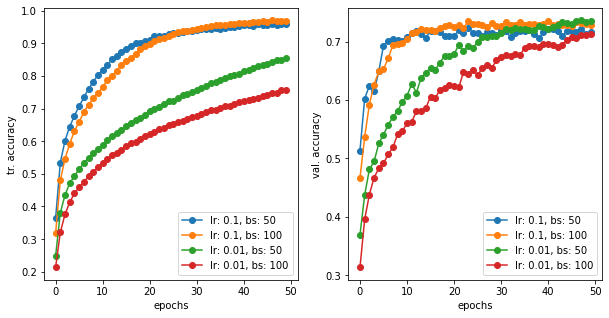

In [ ]:
#plot training and validation accuracies vs epoch for each parameter
fig, axs = plt.subplots(1,2, figsize = (10,5))
# legend names
legend_names = []
for par, acc, v_acc in zip(params, accuracies, val_accuracies):
  legend_names.append( f'lr: {par[0]}, bs: {par[1]}' )
  axs[0].plot(acc, 'o-')
  axs[1].plot(v_acc, 'o-')
# name axis
# displays training and validation accuracy over epochs for 4 different setups
# based on this we can choose the most suitable to compare with resnet50
for ax in axs:
  ax.legend(legend_names)
  ax.set_xlabel('epochs')
axs[0].set_ylabel('tr. accuracy')
axs[1].set_ylabel('val. accuracy')
fig.show()

Train and evaluate most sutiable model based on parameter tuning.

In [ ]:
#evaluate most suitable model
lr_best = 1e-1
bs_best = 100
# train and evaluate best model over 20 epochs (20 as resnet requires long training times)
model_best = define_model(lr_best)
_, history_best = train_and_evaluate_model(model_best, x_train, y_train, x_test, y_test, 20, bs_best)

Classsification report and confusion matrix for my model

In [ ]:
#classification report for my model to compare and evaluate
y_pred = model_best.predict(x_test)
y_pred_classes = [np.argmax(label) for label in y_pred]
y_test_classes = [np.argmax(label) for label in y_test]
# prints classification report
print("Classification report: \n", classification_report(y_test_classes, y_pred_classes))

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.76      0.78      1000
           1       0.85      0.79      0.82      1000
           2       0.68      0.62      0.65      1000
           3       0.52      0.57      0.55      1000
           4       0.67      0.74      0.70      1000
           5       0.64      0.55      0.59      1000
           6       0.77      0.82      0.79      1000
           7       0.81      0.75      0.78      1000
           8       0.83      0.85      0.84      1000
           9       0.75      0.83      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



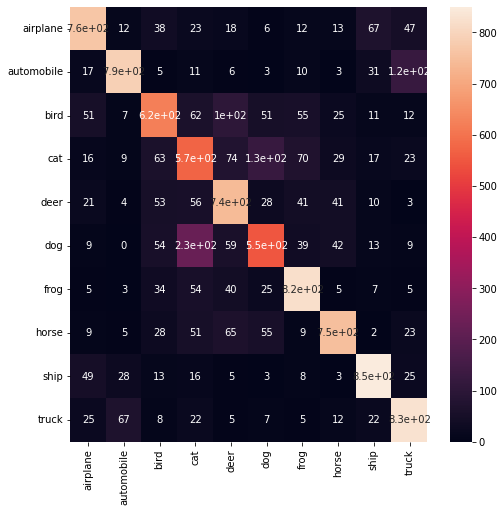

In [ ]:
#plotting mymodel confusion matrix for comparison and evaluation
pred  = model_best.predict(x_test)
pred_for_mymodel = pred.argmax(1)
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
conmat = confusion_matrix(y_test_classes,pred_for_mymodel)
plt.figure(figsize=(8,8))
sns.heatmap(conmat, annot=True,  xticklabels=class_names, yticklabels = class_names)

Define, train and print model architecture for resnet model.

In [ ]:
#define train and evaluate resnet model over 20 epochs
model_resnet = define_resnet_50(1e-1)
_, history_resnet = train_and_evaluate_model(model_resnet, x_train, y_train, x_test, y_test, 20, 50)

In [ ]:
#resnet model classsification report for comparison
y_pred = model_resnet.predict(x_test)
y_pred_classes = [np.argmax(label) for label in y_pred]
y_test_classes = [np.argmax(label) for label in y_test]
# print classification report
print("Classification report: \n", classification_report(y_test_classes, y_pred_classes))

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.64      0.67      1000
           1       0.78      0.71      0.75      1000
           2       0.50      0.43      0.46      1000
           3       0.41      0.30      0.35      1000
           4       0.54      0.61      0.57      1000
           5       0.54      0.53      0.53      1000
           6       0.65      0.78      0.71      1000
           7       0.66      0.70      0.68      1000
           8       0.69      0.80      0.74      1000
           9       0.72      0.74      0.73      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



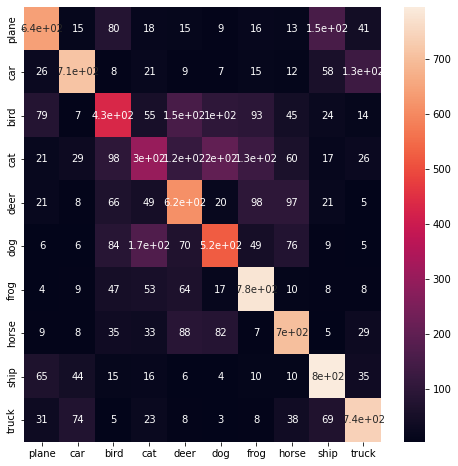

In [ ]:
#plotting resnet confusion matrix for comparison
pred_resnet = model_resnet.predict(x_test)
pred_for_resnet = pred_resnet.argmax(1)
class_names = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]
conmat = confusion_matrix(y_test_classes,pred_for_resnet)
plt.figure(figsize=(8,8))
sns.heatmap(conmat, annot=True,  xticklabels=class_names, yticklabels = class_names)

Compare my model accuracy with resnet accuracy

In [ ]:
#compare resnet to my model by finding validation accuracy difference
my_model_acc = history_best.history['val_accuracy'][-1]
resnet_model_acc = history_resnet.history['val_accuracy'][-1]
# print validation accuracy differnce between 2 models as a comparison
print(f'Validation accuracy difference between pre trained resnet model and my own model is { int( 100 * (resnet_model_acc-my_model_acc))} %')

Validation accuracy difference between pre trained resnet model and my own model is -10 %
